# Multivariate linear regression 

### Can we predict the wordlwide profit of a movie if we know the domestic profit and profit made during the opening weekend?
Movie dataset from Kaggle

#### Methodology
1. Read in data (csv file)
2. Transform data (remove unwanted features, augment the string values, change column types)
3. Split data into train and test splits
4. Build six linear regression models using scikit learn
5. Perform cross validation and hyperparameter tuning
6. Use the final model to make predictions

# Preamble - load modules and setup environment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data split
from sklearn.model_selection import train_test_split
# regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# metrics
from sklearn.metrics import r2_score, mean_absolute_error
# model evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.exceptions import NotFittedError

In [3]:
# use LaTeX text for figures
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Load and transform data

In [4]:
# read csv file
df = pd.read_csv('movies.csv')

# remove letters from numeric values (so they can be type converted from object to numeric)
c = ['production_cost', 'domestic_gross', 'worldwide_gross','opening_weekend']
pattern = '|'.join(['M',','])
for label in c:
    df[label] = df[label].str.replace(pattern, '', regex=True)
    df[label] = pd.to_numeric(df[label])
df.loc[(df['genre'] != 'Action') & (df['genre'] != 'Adventure'), 'genre'] = 'Other'

# Choose columns to use
df = df[['domestic_gross', 'opening_weekend', 'worldwide_gross']]

df.head
df0 = df

# Split data

In [5]:
# split dataframe into features and observations
X, y = df.to_numpy()[:, :-1], df.to_numpy()[:, -1]

# set the percentage of data to use in the training set
train_prop = 0.8

# split entire data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_prop)

print('Training set has {} values'.format(len(X_train)))
print('Test set has {} values'.format(len(X_test)))

Training set has 194 values
Test set has 49 values


def reg_fun(data):
    train, valid, test = np.split(data.sample(frac=1), [int(0.8*len(data)), int(0.9*len(data))]) # shuffle data
    lin_reg = LinearRegression()
    X=data['Weight'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
    y=data['Height'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
    lin_reg.fit(X,y)
    
    X_test=test['Weight'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
    y_test=test['Height'].values.reshape(-1,1) # this  has shape (XXX, 1) - it's 2D
    y_pred = lin_reg.predict(X_test)
    print(lin_reg.intercept_, lin_reg.coef_, lin_reg.score(X_test, y_test))
    return lin_reg

# Develop Regression Models

In [6]:
# define different regression models to investigate in a dictionary
# pass model type and lists of parameters to use in the parameter tuning/search
model_dict = {
    'linear_model': {
        'model': LinearRegression(),
        'params' : {}
        },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [1,5,10],
            'max_depth' : [5,6,8],
            'min_samples_split' : [2,4,6],
            'min_samples_leaf' : [1,2,3]
        }
    },
    'lasso' : {
        'model' : Lasso(),
        'params' : {
            'alpha' : [1e-3, 5e-2, 1e-1, 5e-1, 0.99]
        }
    },
    'ridge' : {
        'model' : Ridge(),
        'params' : {
            'alpha' : [1e-3, 5e-2, 1e-1, 5e-1, 0.99]
        }
    },
    'elast_net' : {
        'model' : ElasticNet(),
        'params' : {
            'alpha' : [1e-3, 5e-2, 1e-1, 5e-1, 0.99]
        }
    },
    'grad_boost' : {
        'model' : GradientBoostingRegressor(),
        'params' : {
            'alpha' : [1e-3, 5e-2, 1e-1, 5e-1, 0.99]
        }
    }
}
model_dict

{'linear_model': {'model': LinearRegression(), 'params': {}},
 'random_forest': {'model': RandomForestRegressor(),
  'params': {'n_estimators': [1, 5, 10],
   'max_depth': [5, 6, 8],
   'min_samples_split': [2, 4, 6],
   'min_samples_leaf': [1, 2, 3]}},
 'lasso': {'model': Lasso(),
  'params': {'alpha': [0.001, 0.05, 0.1, 0.5, 0.99]}},
 'ridge': {'model': Ridge(),
  'params': {'alpha': [0.001, 0.05, 0.1, 0.5, 0.99]}},
 'elast_net': {'model': ElasticNet(),
  'params': {'alpha': [0.001, 0.05, 0.1, 0.5, 0.99]}},
 'grad_boost': {'model': GradientBoostingRegressor(),
  'params': {'alpha': [0.001, 0.05, 0.1, 0.5, 0.99]}}}

In [7]:


# carry out k-fold cross-validation using either a grid or random search over the options provided in the model dictionary
def cv_accuracy(search_type, number_folds, model_dct):
    """Function to carry out cross-validation
    input - search_type [str] - specify grid or random search for cross validation
          - number_folds [int] - number of folds to divide the training set into 
          - model_dict [dict] - dictionary of regression models and parameters to investigate
          
    output - df [dataframe] - list of best performing model of each type (with score and parameters)
    """
    fit_models = {}
    scores = []
    for model_name, mp in model_dct.items():
        if search_type == 'grid':
            clf =  GridSearchCV(mp['model'], mp['params'], cv=number_folds, return_train_score=False, n_jobs=-1)
        elif search_type == 'random':
            clf =  RandomizedSearchCV(mp['model'], mp['params'], cv=number_folds, return_train_score=False, n_iter=3)
        else:
            print('Try a different flag for search_type')
            break
        
        try:
            print('Starting training for {}.'.format(model_name))
            clf.fit(X_train, y_train)
            fit_models[model_name] = clf
            scores.append({
                'model': model_name,
                'best_score': clf.best_score_,
                'best_params': clf.best_params_})
            print('{} has been successfully fit.'.format(model_name))
        except NotFittedError as e:
            print(repr(e))
                
    df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
    df=df.sort_values('best_score', ascending=False)
    return df, fit_models

scores, fit_mod = cv_accuracy('grid', 4, model_dict)

Starting training for linear_model.
linear_model has been successfully fit.
Starting training for random_forest.
random_forest has been successfully fit.
Starting training for lasso.
lasso has been successfully fit.
Starting training for ridge.
ridge has been successfully fit.
Starting training for elast_net.
elast_net has been successfully fit.
Starting training for grad_boost.
grad_boost has been successfully fit.


In [9]:
scores

,model,best_score,best_params
2,lasso,0.781518,{'alpha': 0.99}
4,elast_net,0.781513,{'alpha': 0.99}
3,ridge,0.781499,{'alpha': 0.99}
0,linear_model,0.781499,{}
1,random_forest,0.765593,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s..."
5,grad_boost,0.708520,{'alpha': 0.99}


In [11]:
# assign best model
best_model = fit_mod['lasso']
best_model

GridSearchCV(cv=4, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.05, 0.1, 0.5, 0.99]})

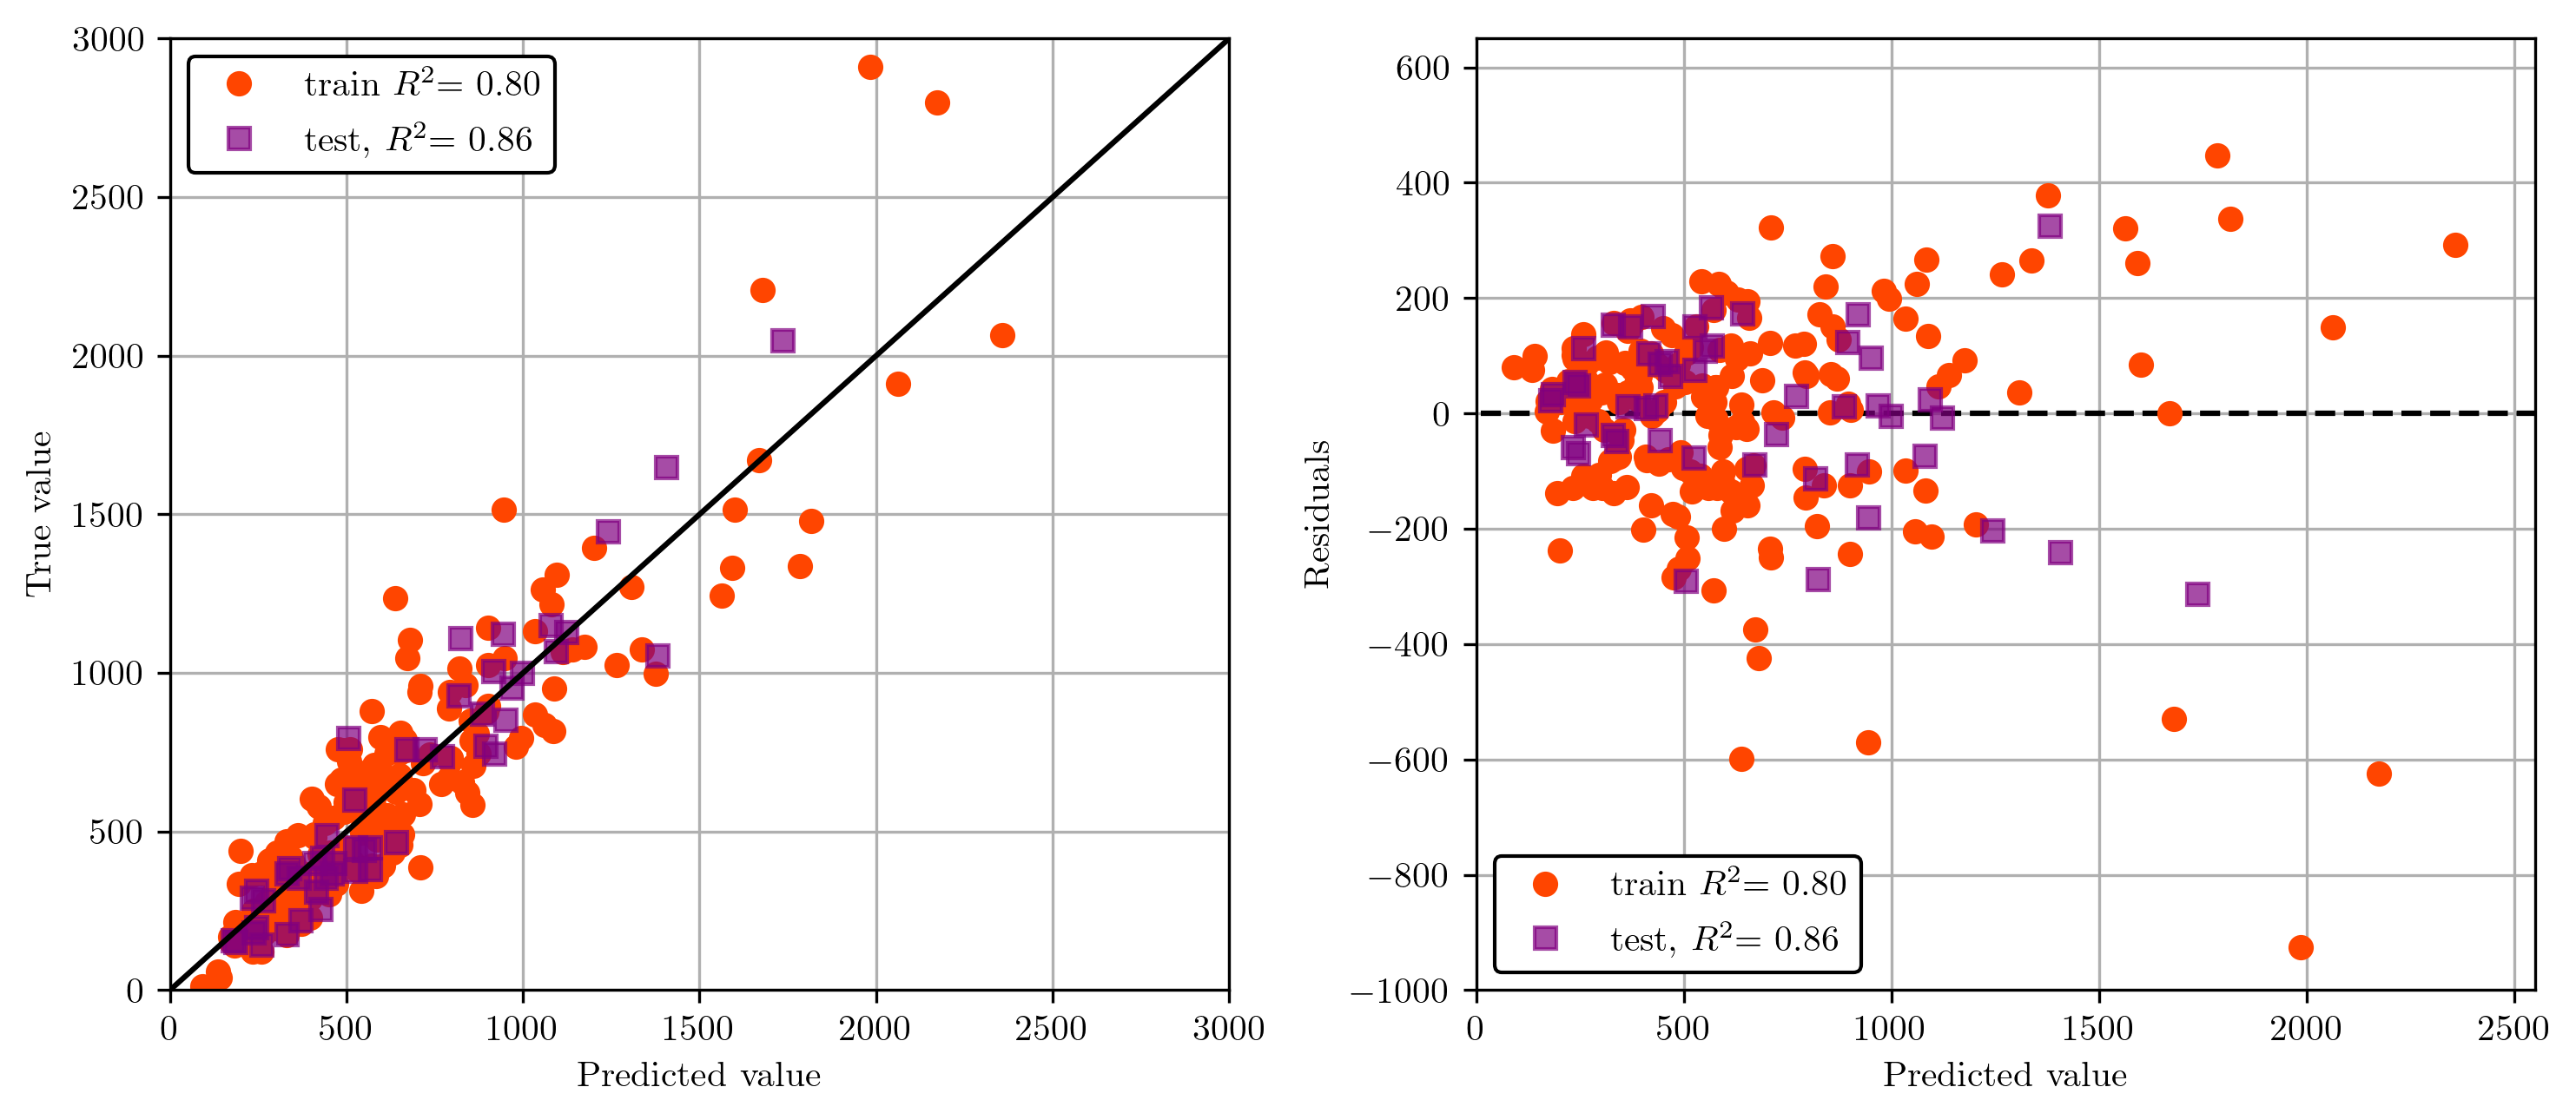

array([ 245.36059229,  365.14653233, 1241.71338029,  257.79166346,
        235.83754604,  425.77431536,  329.64217284, 1735.66609573,
        943.03173988,  369.60911727,  244.75219439,  466.66140612,
        178.64368878,  884.90918649,  336.66656751,  966.90580268,
       1078.97912869,  894.16410591,  670.44894054,  504.27889025,
       1380.52173516,  997.51165298, 1406.51186576,  457.89685055,
        329.39294861,  721.77644947,  430.88848351,  822.52611469,
        232.76963956,  916.55071031,  184.49905037,  565.68116443,
        949.84812389,  566.42947104, 1122.10225203,  523.24435862,
        816.48225008,  442.01278227,  640.16312092, 1092.59623373,
        442.5624307 ,  263.1895226 ,  549.83730938,  408.99708794,
        769.4608529 ,  918.03950651,  525.47902449,  525.47865811,
        414.14184929])

In [15]:
# visualise performance of model - residuals between predictions and real data
plt.figure(figsize=(10,4.4), dpi=300)
ax1 = plt.subplot(1,2,1)
plt.plot(best_model.predict(X_train),y_train,'o', color='orangered', label='train $R^2$= {0:.2f}'.format(r2_score(best_model.predict(X_train),y_train)))
plt.plot(best_model.predict(X_test), y_test,'s', color='purple', alpha=0.7, label='test, $R^2$= {0:.2f}'.format(r2_score(best_model.predict(X_test),y_test)))
plt.plot([0,3e3],[0,3e3],'k-')
plt.grid(zorder=-1)    
plt.xlabel('Predicted value'); plt.ylabel('True value')
plt.legend(framealpha=1, edgecolor='k', fontsize = 10, loc=2)
plt.axis([0,3000, 0,3000])

plt.subplot(1,2,2)
plt.plot([1e1,1e4],[0,0],'k--')
plt.plot(best_model.predict(X_train), best_model.predict(X_train)-y_train,'o', color='orangered', label='train $R^2$= {0:.2f}'.format(r2_score(best_model.predict(X_train),y_train)))
plt.plot(best_model.predict(X_test), best_model.predict(X_test)-y_test,'s', color='purple', alpha=0.7, label='test, $R^2$= {0:.2f}'.format(r2_score(best_model.predict(X_test),y_test)))
plt.grid(zorder=-1)    
plt.xlabel('Predicted value'); plt.ylabel('Residuals')
plt.legend(framealpha=1, edgecolor='k', fontsize = 10, loc=3)
plt.axis([0,2550, -1000,650])


plt.tight_layout()
plt.show()
# plot residuals to visually inspect performance of the best model


scores
fit_mod['lasso'].predict(X_test)
#X_test.shape, y_test.shape
#best_model.predict(X_train, y_train)

# Interact with the final model

In [16]:

yhat = best_model.predict(X_test)
print('Lasso model scores - R2 : {} MAE : {}'.format(r2_score(yhat ,y_test), mean_absolute_error(yhat, y_test)))

best_model.best_estimator_.coef_, 
best_model.best_estimator_.intercept_

Lasso model scores - R2 : 0.864025782202372 MAE : 102.31758883461445


86.303744216778

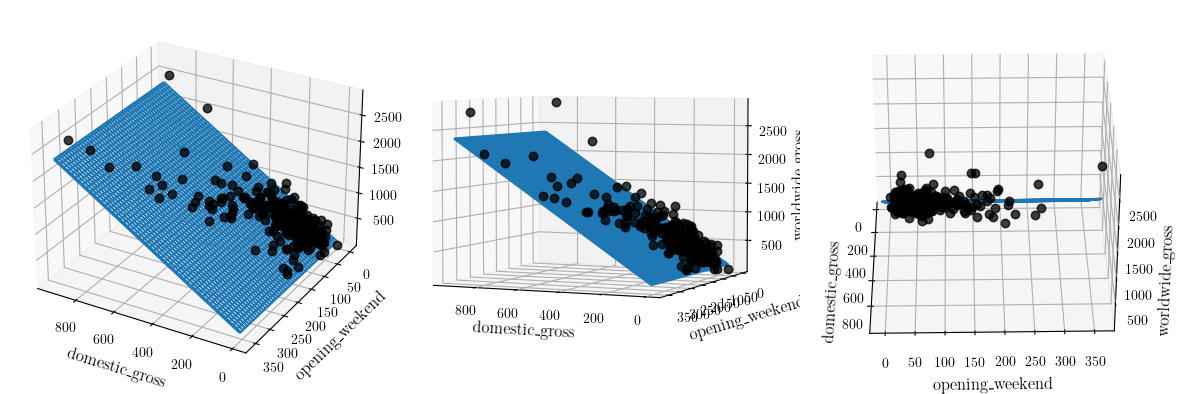

In [17]:
from mpl_toolkits.mplot3d import Axes3D
xx, yy = np.meshgrid(X_test[:,0], X_test[:,1])


fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(X[:,0], X[:,1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.plot(X[:,0], X[:,1], y, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    #ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    
    samples = 100
    xx, yy = np.meshgrid(np.linspace(min(X[:,0]), max(X[:,0]), samples), np.linspace(min(X[:,1]), max(X[:,1]), samples))
    # to see the decision boundaries(not the right word for a decision tree regressor, I think)
    ax.plot_wireframe(xx, yy, best_model.predict(np.hstack((xx.reshape(-1,1), yy.reshape(-1,1)))).reshape(xx.shape))


    ax.set_xlabel('domestic_gross', fontsize=12)
    ax.set_ylabel('opening_weekend', fontsize=12)
    ax.set_zlabel('worldwide_gross', fontsize=12)
    #ax.locator_params(nbins=4, axis='x')
    #ax.locator_params(nbins=5, axis='x')

#ax1.text2D(0.2, 0.32, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#           transform=ax1.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)


fig.tight_layout()
for ii in np.arange(0, 360, 1):
    ax.view_init(elev=32, azim=ii)
    #fig.savefig('gif_image%d.png' % ii)